In [1]:
# !pip install category_encoders
# !pip install missingno
# !pip install --user imblearn

import warnings
warnings.simplefilter('ignore')

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Очень жаль, что вывод всех ячеек пропал, так как в данной среде нужно 3-7 часов, чтобы заного прогнать весь этот код.  
    В самой первой ячейке были строки с для установки дополнительных библиотек с которыми код запускается в среде Яндекс.Практикума. Они были закоментированы, чтобы после перезапуска ядра убрать лишнюю системную информацию об установке с проекта. Правда после последнего обновления иногда требуется несколько раз их переустановить, чтобы все заработало.
</div>

<div class="alert alert-block alert-success">
<b>Комментарий от ревьюера v2</b>
    
<b>Успех:</b> Если в проекте есть особенности запуска, то лучше о них предупреждать в начале проекта, тогда можно избежать таких недопониманий)
</div>

Привет, меня зовут Дмитрий Акимов и я буду проверять твой проект.
<br>Небольшая вступительная часть и начнем работу)
<br> Если не против, то предлагаю общаться на «ты». Если это не удобно - дай знать, и мы перейдем на "вы". Моя основная цель — не указать на совершенные ошибки, а поделиться своим опытом и помочь сделать твой проект лучше. Для этого я буду использовать разный стиль оформления комментариев. 
<div class="alert alert-block alert-success">
<b>Успех:</b> Все хорошо.
</div>

<div class="alert alert-warning">
<b>Рекомендация:</b> Критических замечаний нет, но есть возможность сделать твою работу лучше.
</div>

<div class="alert alert-block alert-danger">
<b>Необходимо исправить:</b> Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>

<div class="alert alert-block alert-info">
<b>Совет:</b> В таких комментариях я постараюсь оставлять полезные советы)
</div>

Давай работать над проектом в диалоге: если ты что-то меняешь в проекте по моим рекомендациям — пиши об этом.
Будет очень хорошо, если ты будешь помечать свои действия следующим образом:
<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> ...
</div>
Пожалуйста, не перемещай, не изменяй и не удаляй мои комментарии. Всё это поможет выполнить повторную проверку твоего проекта оперативнее». 


# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение в котором можно быстро узнать рыночную стоимость своего автомобиля. В распоряжении исторические данные.  

Нужно:
- построить модель для определения стоимости 
- помимо качества предсказания, учитывать скорость предсказания и время обучения
- для оценки качества моделей использовать метрику RMSE
- в качестве одной из моделей использовать LightGBM

## Знакомство с данными

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import missingno as msno
import time

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import category_encoders as ce
from imblearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

RANDOM_SEED = 42

<div class="alert alert-block alert-danger">
<b>Комментарий от ревьюера v1</b>
    
<b>Необходимо исправить:</b> К сожалению, ты используешь библиотеки, которых нет в среде Практикума, я попытаюсь проверить проект без запуска, но чтобы я принял работу это необходимо будет исправить.

</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Комментарий дал выше
</div>

In [3]:
df = pd.read_csv('/datasets/autos.csv', parse_dates=['DateCrawled', 'LastSeen', 'DateCreated'])

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


<div class="alert alert-warning">
<b>Комментарий от ревьюера v1</b>
    
<b>Рекомендация:</b> Лучше ограничивать вывод таблицы методами .head() или .tail(), иначе тетрадка может стать слишком тяжелой.
</div>


<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> исправил
</div>

Согласно приложенной документации, в колонках содержется следующая информация:  

**Признаки**  
*DateCrawled* — дата скачивания анкеты из базы  
*VehicleType* — тип автомобильного кузова  
*RegistrationYear* — год регистрации автомобиля  
*Gearbox* — тип коробки передач  
*Power* — мощность (л. с.)  
*Model* — модель автомобиля  
*Kilometer* — пробег (км)  
*RegistrationMonth* — месяц регистрации автомобиля  
*FuelType* — тип топлива  
*Brand* — марка автомобиля  
*NotRepaired* — была машина в ремонте или нет  
*DateCreated* — дата создания анкеты  
*NumberOfPictures* — количество фотографий автомобиля  
*PostalCode* — почтовый индекс владельца анкеты (пользователя)  
*LastSeen* — дата последней активности пользователя  

**Целевой признак**  
*Price* — цена (евро)  

Приведем названия колонок в соответствие с хорошим стилем


In [5]:
def small_snaker(word:str)->str:
  for symbol in set(word):
    if not symbol.islower():
      word = word.replace(symbol, '_'+symbol)
  return word[1:].lower()

In [6]:
df.columns = [small_snaker(column) for column in df.columns]

In [7]:
df.isna().mean()*100

date_crawled           0.000000
price                  0.000000
vehicle_type          10.579368
registration_year      0.000000
gearbox                5.596709
power                  0.000000
model                  5.560588
kilometer              0.000000
registration_month     0.000000
fuel_type              9.282697
brand                  0.000000
not_repaired          20.079070
date_created           0.000000
number_of_pictures     0.000000
postal_code            0.000000
last_seen              0.000000
dtype: float64

Имеется значительное количество пропусков в колонках `model`, `gearbox`, `fuel_type`, `vehicle_type`, `not_repaired`

<div class="alert alert-block alert-success">
<b>Комментарий от ревьюера v1</b>
    
<b>Успех:</b> Отлично, пропуски в данных есть и их надо обработать.
</div>

### Dates

In [8]:
df.date_crawled.sort_values()

329497   2016-03-05 14:06:22
220583   2016-03-05 14:06:23
176823   2016-03-05 14:06:24
99885    2016-03-05 14:06:24
324763   2016-03-05 14:06:24
                 ...        
204218   2016-04-07 14:36:53
53739    2016-04-07 14:36:54
301030   2016-04-07 14:36:55
339649   2016-04-07 14:36:56
90713    2016-04-07 14:36:58
Name: date_crawled, Length: 354369, dtype: datetime64[ns]

In [9]:
df.date_created.sort_values()

61207    2014-03-10
4001     2015-03-20
342275   2015-06-18
86601    2015-08-07
175103   2015-08-10
            ...    
134418   2016-04-07
176987   2016-04-07
206303   2016-04-07
309336   2016-04-07
305430   2016-04-07
Name: date_created, Length: 354369, dtype: datetime64[ns]

In [10]:
df.last_seen.sort_values() 

296785   2016-03-05 14:15:08
262341   2016-03-05 14:15:16
130462   2016-03-05 14:15:39
285695   2016-03-05 14:18:30
169065   2016-03-05 14:25:59
                 ...        
54852    2016-04-07 14:58:50
59506    2016-04-07 14:58:50
116344   2016-04-07 14:58:50
215705   2016-04-07 14:58:50
327303   2016-04-07 14:58:51
Name: last_seen, Length: 354369, dtype: datetime64[ns]

Данные предоставлены по большей части за один, 2016 год.  Эта информация не является ценной при предсказании цены.

<div class="alert alert-block alert-success">
<b>Комментарий от ревьюера v1</b>

👍
</div>

### Model

In [11]:
df.model.unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [12]:
df.model.value_counts()

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
serie_1                   2
range_rover_evoque        2
Name: model, Length: 250, dtype: int64

По моделям данные корректны

### VehicleType

In [13]:
df.vehicle_type.value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64

Кроме пропусков имеется `other` для автомобилей которым по неизвестным причинам не подошел один из стандартный типов кузова. Казалось бы эти данные можно попробовать востановить по схожим моделям. Но рассмотрим на примере самой популярной модели.

In [14]:
df[(df.brand == 'volkswagen') & (df.model == 'golf')].pivot_table(index='vehicle_type',
                                                                  values='price',
                                                                  aggfunc=['mean', 'count']).reset_index()

,vehicle_type,mean,count
,,price,price
0,bus,8488.322368,760
1,convertible,3855.640163,1962
2,coupe,4645.261072,429
3,other,3154.859459,185
4,sedan,4921.943435,14744
5,small,1983.397341,3911
6,suv,5655.720000,25
7,wagon,4525.200880,3181


Автобус VW Golf. Звучит так, что либо мне не хватает знаний о рассматриваемой отрасли, либо что данные не совсем корректны. Поэтому оставим их без изменений

<div class="alert alert-block alert-success">
<b>Комментарий от ревьюера v1</b>
    
<b>Успех:</b> Действительно, очень смелое предположение, которое сразу не бьется с жизнью)
</div>

### RegistrationYear 

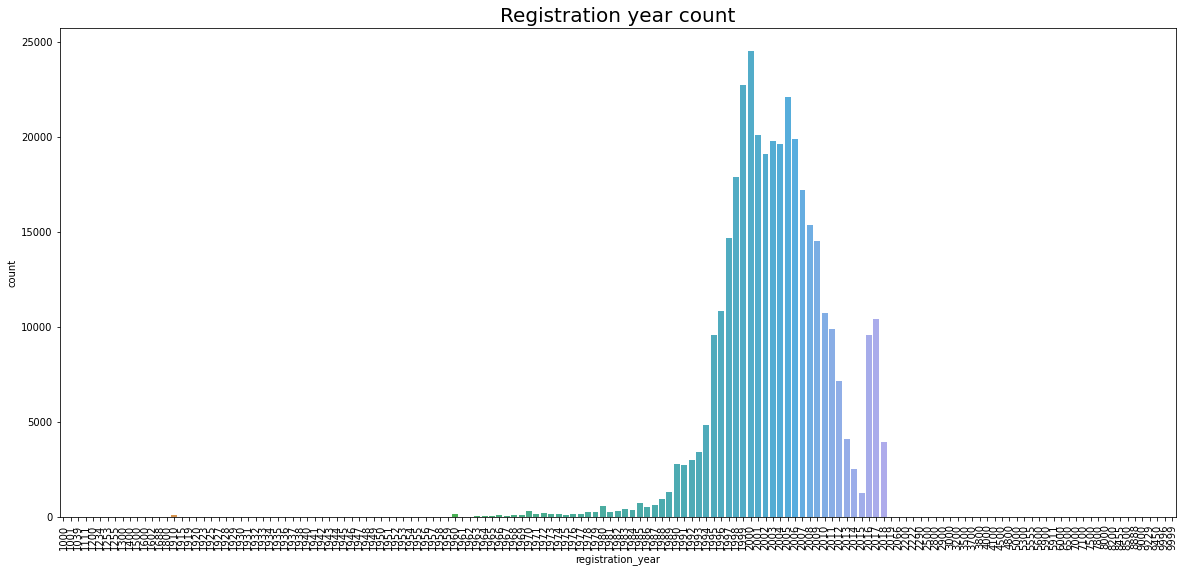

In [15]:
plt.figure(figsize=(20,9))
plt.title('Registration year count', fontsize=20)
plt.xticks(rotation=90)
sns.countplot(df.registration_year);

Не малая доля заполнявших данные решили указать ложный год. В том числе группа 2016-2018 годов, так как известно, что информация формировалась в 2016

<div class="alert alert-block alert-success">
<b>Комментарий от ревьюера v1</b>
    
<b>Успех:</b> Хорошо, что ты не забываешь, что мы ограничены 2016 годом.
</div>

### Gearbox 

In [16]:
df.gearbox.value_counts()

manual    268251
auto       66285
Name: gearbox, dtype: int64

Помимо пропусков указаны 2 типа коробок передач

### Power

<AxesSubplot:title={'center':'Power distribution'}>

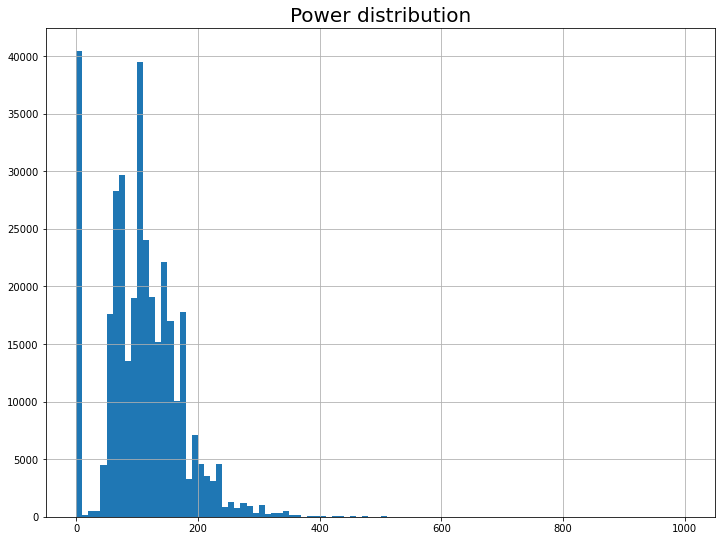

In [17]:
plt.figure(figsize=(12,9))
plt.title('Power distribution', fontsize=20)
df.power.hist(bins=100,  range=(0, 1000))

И тут не обошлось без шутников

### Kilometer

<AxesSubplot:title={'center':'Mileage'}>

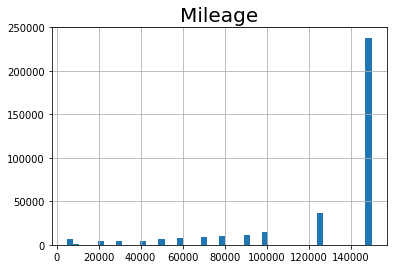

In [18]:
plt.title('Mileage', fontsize=20)
df.kilometer.hist(bins=50)

Данные округлены и основная часть автомобилей с пробегом 150 тыс. км.

### FuelType

In [19]:
df.fuel_type.value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

In [20]:
print(f"Средняя цена автомобилей petrol: {df[df.fuel_type == 'petrol'].price.mean()}")
print(f"Средняя цена автомобилей gasoline: {df[df.fuel_type == 'gasoline'].price.mean()}")

Средняя цена автомобилей petrol: 3750.024432406449
Средняя цена автомобилей gasoline: 6579.760139789303


Так как данные из вселенной где petrol и gasoline это значительно различающиеся типы топлива, оставим признак без изменений

<div class="alert alert-block alert-success">
<b>Комментарий от ревьюера v1</b>
    
<b>Успех:</b> Можно было бы провести сравнение распределений, чтобы убедиться, что мы можем считать эти два признака разными, ведь petrol и gasoline это один тип топлива.
</div>

### Brand

In [21]:
df.brand.unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

### NotRepaired

In [22]:
df.not_repaired.value_counts()

no     247161
yes     36054
Name: not_repaired, dtype: int64

### NumberOfPictures

In [23]:
df.number_of_pictures.value_counts()

0    354369
Name: number_of_pictures, dtype: int64

В данном случае не важно по какой причине, но данных нет и признак бесполезен

### RegistrationMonth

In [24]:
df.registration_month.value_counts().sort_index()

0     37352
1     23219
2     21267
3     34373
4     29270
5     29153
6     31508
7     27213
8     22627
9     23813
10    26099
11    24186
12    24289
Name: registration_month, dtype: int64

Нулевой месяц позволит отсеять те записи, в которых данные намеренно заполняются не корректно, в остальном признак не нужен

### PostalCode

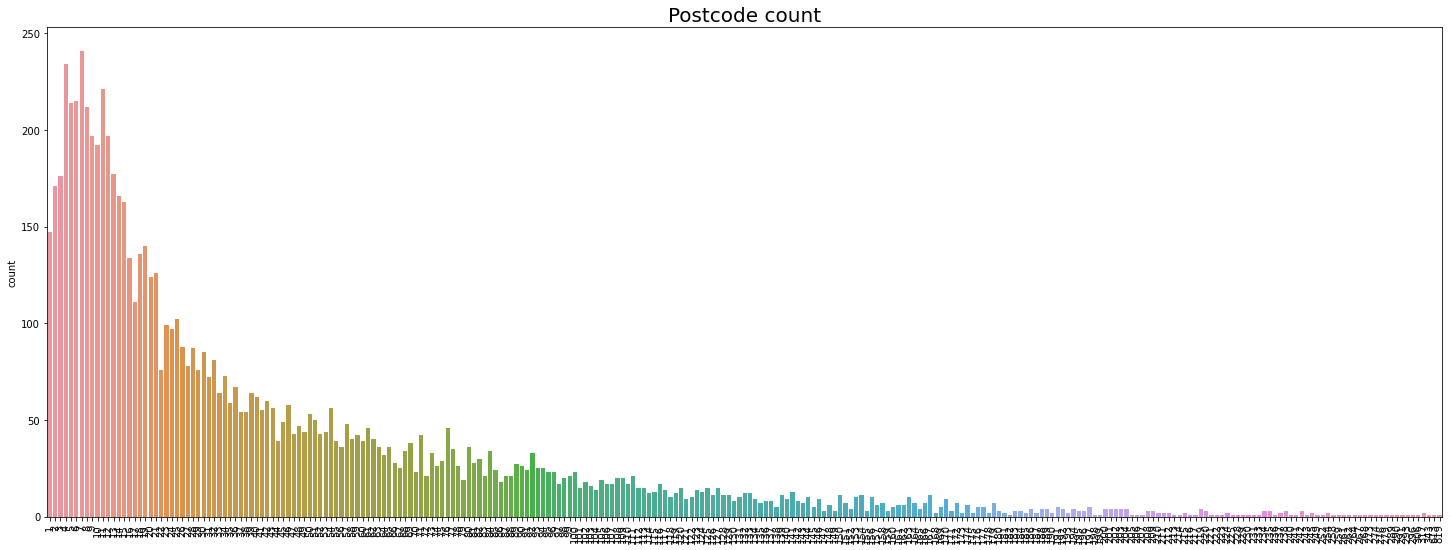

In [25]:
plt.figure(figsize=(25,9))
plt.xticks(rotation=90)
plt.title('Postcode count', fontsize=20)
sns.countplot(df.postal_code.value_counts().values);

Почтовые индексы. Вероятней всего Немецкие. Большая часть малочисленны, вероятно это частные объявления. Но есть Большое количество объявлений из одного района. Скорей всего там располагаются крупные магазины также выставляющие автомобиле на площадке.

### Price

<AxesSubplot:title={'center':'Price count'}, xlabel='price', ylabel='count'>

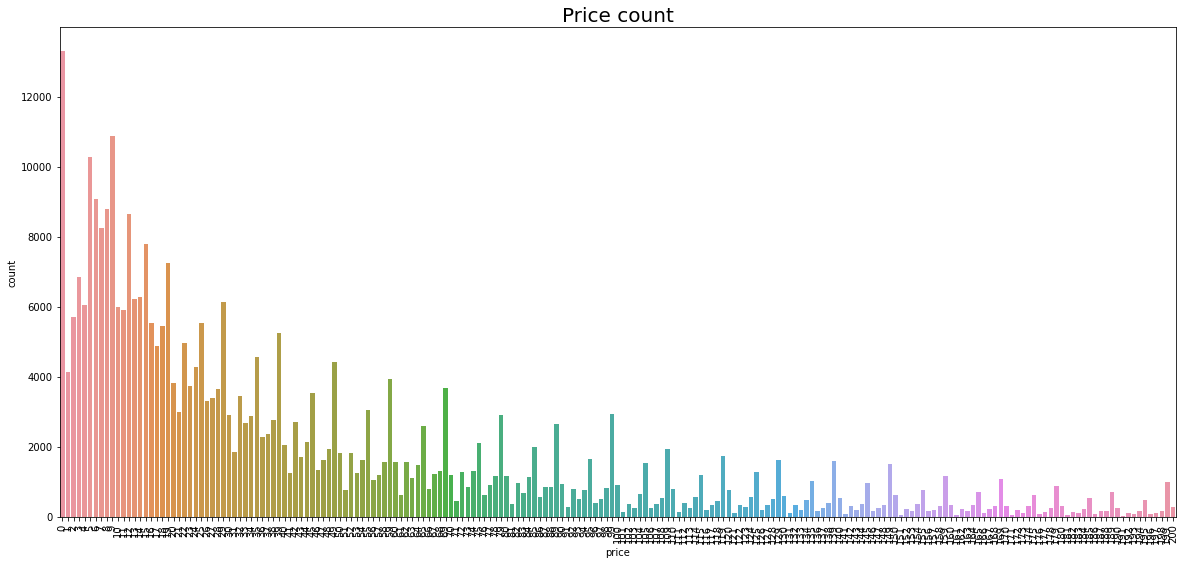

In [26]:
plt.figure(figsize=(20,9))
plt.title('Price count', fontsize=20)
plt.xticks(rotation=90)
sns.countplot(df.price//100)

Околонулевые значения, не смотря на их природу, нам не пригодятся.

### Duplicated

Если убрать дату, предположив, что объявление было выложено повторно позднее, а также не сравнивать по столбцам с пропусками, исключив тем самым одинаковые объявления но загруженные с ошибкой, получим количество возможных дубликатов

In [27]:
df.drop(['vehicle_type',
         'gearbox',
         'model',
         'fuel_type',
         'not_repaired',
         'date_crawled',
         'date_created',
         'last_seen'], axis=1).duplicated().sum()

28901

<div class="alert alert-block alert-success">
<b>Комментарий от ревьюера v1</b>
    
<b>Успех:</b> Отличное исследование признаков, круто, что ты рассмотрел каждый, нашел проблемы и наметил пути их решения. По PostalCode могу посоветовать оставить только 2 первых цифры кода, это номер почтового региона Германии. И вместо того, чтобы искать дубли удаляя признаки, лучше воспользоваться свойством subset метода duplicated().
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Я пробовал "извращаться" с PostalCode. Но наименьшая ошибка была, когда его просто удаляешь 
</div>

## Предобработка

Взглянем на шутников

<AxesSubplot:>

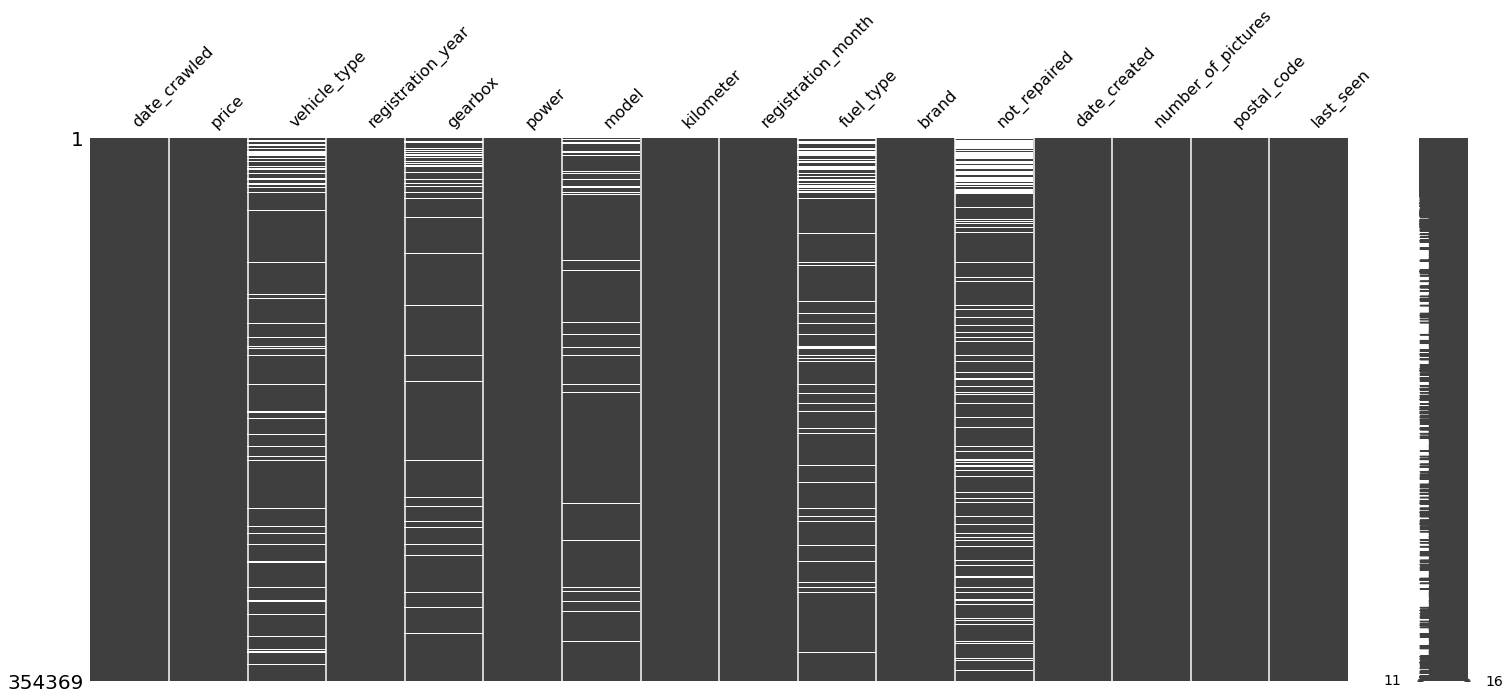

In [28]:
msno.matrix(df.sort_values(by='registration_month'))

<AxesSubplot:>

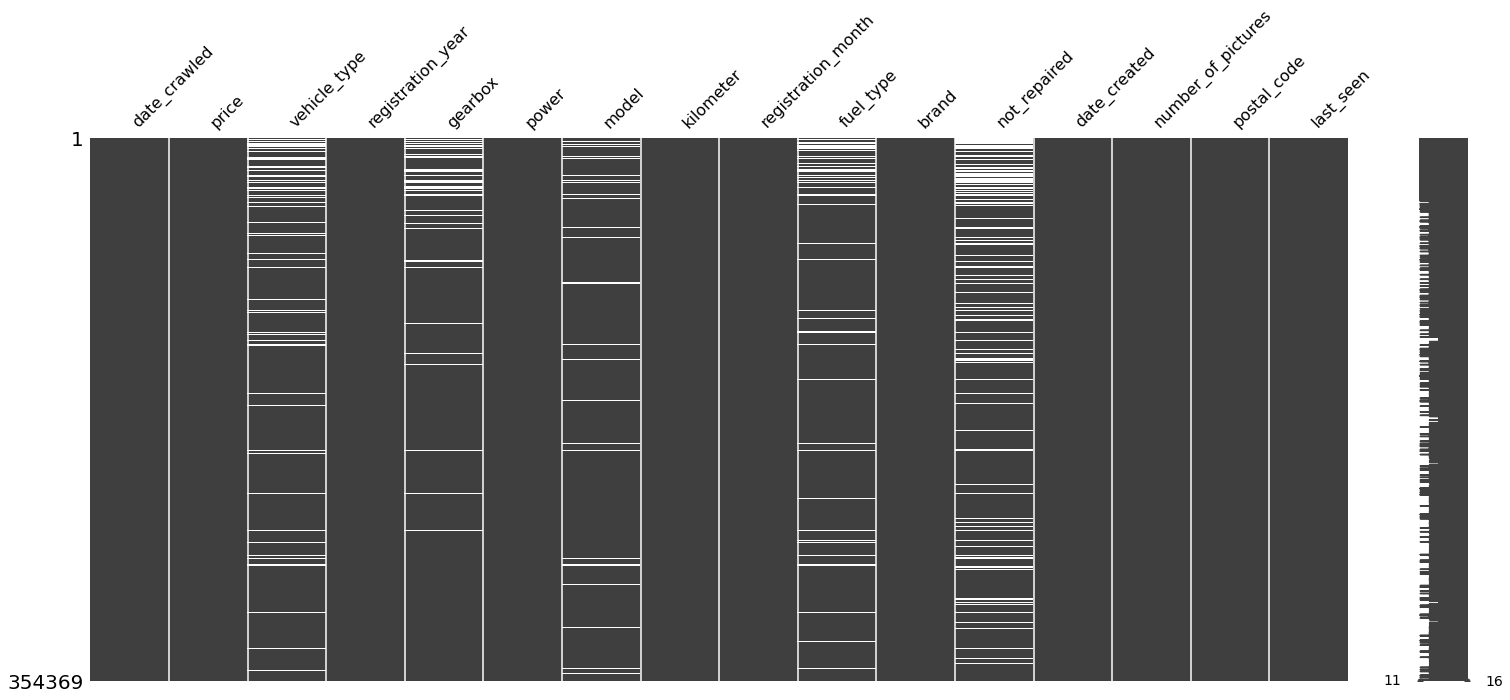

In [29]:
msno.matrix(df.sort_values(by='power'))

<AxesSubplot:>

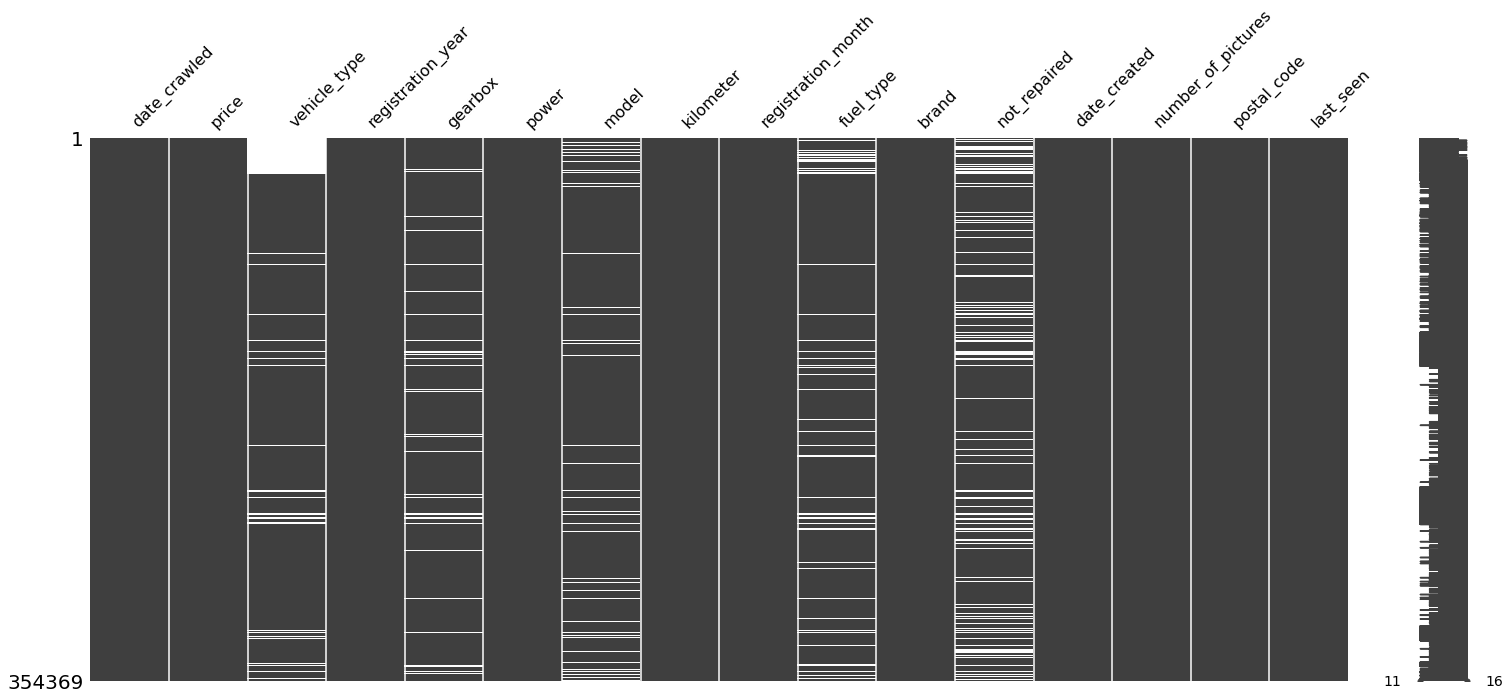

In [30]:
msno.matrix(df.sort_values(by='registration_year', ascending=False))

Некорректные записи аккумулируют в себе в том числе и большое число пропусков. Удалим эти "шуточные" строки.  
А также записи с годом регистрации старше 1990, так как записи малочислены и цена во многом характеризуется техническим состоянием автомобиля не отображенным в данных.  
Записи с сверхнизкой ценой в нашем случае тоже будем считать не релевантными.

In [31]:
df = df[(df.registration_year < 2016) &\
        (df.registration_year > 1990) &\
        (df.registration_month != 0) &\
        (df.price >10) &\
        (df.power>50) &\
        (df.power<250)]

In [32]:
df.isna().mean()*100

date_crawled           0.000000
price                  0.000000
vehicle_type           0.950945
registration_year      0.000000
gearbox                1.193554
power                  0.000000
model                  2.684203
kilometer              0.000000
registration_month     0.000000
fuel_type              3.199647
brand                  0.000000
not_repaired          11.423276
date_created           0.000000
number_of_pictures     0.000000
postal_code            0.000000
last_seen              0.000000
dtype: float64

Что уже значительно снизило количество пропусков.

<div class="alert alert-block alert-success">
<b>Комментарий от ревьюера v1</b>
    
<b>Успех:</b> Отлично, лучше сначала избавиться от аномалий, а потом заполнять пропуски. Можно ещё попробовать удалить строки с большим количеством пропусков и избавиться от них.
</div>

Теперь убираем бесполезные признаки

In [33]:
df = df.drop(['date_crawled',
              'number_of_pictures',
              'date_created',
              'last_seen',
              'registration_month'],axis=1)

И дубликаты

In [34]:
df = df.drop_duplicates()

Пропуски в информации о ремонте заполним значениями `unknown`

In [35]:
df['not_repaired'] = df['not_repaired'].fillna('unknown')

Количество остальных пропусков не значительно, поэтому их удалим

In [36]:
df = df.dropna()
df = df.reset_index()

<div class="alert alert-block alert-success">
<b>Комментарий от ревьюера v1</b>
    
<b>Успех:</b> Отлично, идеальная предобработка) 
</div>

## Оценка моделей

Для дальнейшей работы возьмем модели различных типов:  
- LinearRegression
- KNeighborsRegressor
- RandomForestRegressor
- LGBMRegressor
- CatBoostRegressor

Подготовливаем категориальные данные для LGBMRegressor и CatBoostRegressor

In [37]:
cat_features = ['vehicle_type', 'gearbox','model', 'fuel_type', 'brand', 'not_repaired', 'postal_code']
for feature in cat_features:
  df[feature] = df[feature].astype('category')

Разбиваем выборку для обучения

In [38]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('price', axis=1),
                                                    df.price,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED) 

Произведем первичную оценку точности и скорости моделей.

In [39]:
encoders = [
            ce.BaseNEncoder(cols=cat_features),
            ce.BinaryEncoder(cols=cat_features),
            ce.CountEncoder(cols=cat_features),
            ce.HashingEncoder(cols=cat_features),
            ce.OrdinalEncoder(cols=cat_features),
            ce.CatBoostEncoder(cols=cat_features), # 
            ce.JamesSteinEncoder(cols=cat_features),
            ce.MEstimateEncoder(cols=cat_features),
            ce.TargetEncoder(cols=cat_features),
            ce.QuantileEncoder(cols=cat_features),
           
] #используемые энкодеры категориальных признаков


models = [LinearRegression(n_jobs=-1),
          KNeighborsRegressor(n_neighbors=13, weights='distance', n_jobs=-1),
          RandomForestRegressor(n_estimators=300, max_depth=7, random_state=RANDOM_SEED, n_jobs=-1),
          LGBMRegressor(n_estimators=300, random_state=RANDOM_SEED, objective='root_mean_squared_error', n_jobs=-1),
          CatBoostRegressor(n_estimators=300, random_state=RANDOM_SEED, verbose=0)
          ] #используемые модели


rmse_result = pd.DataFrame(columns=[small_snaker(str(model.__class__.__name__)) for model in models],
                           index=[small_snaker(str(encoder.__class__.__name__)) for encoder in encoders]+['without_encoder'],
                           dtype=float) # dataframe с rmse 
model_worktime = rmse_result.copy() # dataframe под время обработки

for i, encoder in enumerate(encoders):
    print(f'{encoder.__class__.__name__}...') # визуализация процесса
    preproc_linear_pipe = make_pipeline(
        encoder,
        PolynomialFeatures(),
        StandardScaler()) # пайплайн для линейной модели
    preproc_knn_pipe = make_pipeline(encoder, StandardScaler()) # пайплайн для knn
    
    models_rmse = [] # список результатов енкодера для всех моделей для дальнейшего добавления в df
    model_time = [] # список времени енкодера для всех моделей для дальнейшего добавления в df

    for model in models:
        
        if model.__class__.__name__ in ['LinearRegression']:
            preproc = preproc_linear_pipe
        elif model.__class__.__name__ in ['KNeighborsRegressor']:
            preproc =  preproc_knn_pipe
        else: preproc = encoder

        model_pipe = Pipeline([ ('prep', preproc), ('model', model) ]) # пайплайн предобработки + модели
        start_time = time.time()
        models_rmse.append(np.absolute(cross_val_score(model_pipe,
                                                       X_train,
                                                       y_train,
                                                       cv=3,
                                                       scoring='neg_root_mean_squared_error').mean()))
        model_time.append(np.round((time.time() - start_time), 2))
        print(f'{model.__class__.__name__} done')
    print(f'...{encoder.__class__.__name__} done')
    print('-'*50)
    model_worktime.iloc[i] = model_time
    rmse_result.iloc[i] = models_rmse

BaseNEncoder...
LinearRegression done
KNeighborsRegressor done
RandomForestRegressor done
LGBMRegressor done
CatBoostRegressor done
...BaseNEncoder done
--------------------------------------------------
BinaryEncoder...
LinearRegression done
KNeighborsRegressor done
RandomForestRegressor done
LGBMRegressor done
CatBoostRegressor done
...BinaryEncoder done
--------------------------------------------------
CountEncoder...
LinearRegression done
KNeighborsRegressor done
RandomForestRegressor done
LGBMRegressor done
CatBoostRegressor done
...CountEncoder done
--------------------------------------------------
HashingEncoder...
LinearRegression done
KNeighborsRegressor done
RandomForestRegressor done
LGBMRegressor done
CatBoostRegressor done
...HashingEncoder done
--------------------------------------------------
OrdinalEncoder...
LinearRegression done
KNeighborsRegressor done
RandomForestRegressor done
LGBMRegressor done
CatBoostRegressor done
...OrdinalEncoder done
---------------------

In [40]:
for model_index, model in enumerate(models):
    if model.__class__.__name__ in ['LGBMRegressor','CatBoostRegressor']:
        if model.__class__.__name__ in ['CatBoostRegressor']:
            model.set_params(cat_features=cat_features)
        start_time = time.time()
        rmse_result.iloc[len(rmse_result)-1,
                             model_index]=(np.absolute(cross_val_score(model,
                                                                       X_train,
                                                                       y_train,
                                                                       cv=3,
                                                                       scoring='neg_root_mean_squared_error').mean()))
        model_worktime.iloc[len(rmse_result)-1,model_index] = np.round((time.time() - start_time), 2)
        # результаты бустингов без обработки категориальных переменных

In [41]:
rmse_result

,linear_regression,k_neighbors_regressor,random_forest_regressor,l_g_b_m_regressor,cat_boost_regressor
base_n_encoder,1719.365612,2495.919808,1983.151748,1490.061899,1484.085646
binary_encoder,1719.365612,2495.919808,1983.151748,1490.061899,1484.085646
count_encoder,1944.136033,1903.762018,1919.592049,1471.755330,1471.046091
hashing_encoder,2044.934765,2137.335209,2014.626917,1773.450349,1790.345563
ordinal_encoder,2018.235157,1899.912802,1958.490956,1473.847109,1479.778967
cat_boost_encoder,1838.230530,1765.664813,1857.401682,1498.493010,1501.923075
james_stein_encoder,1868.782387,1887.162061,1838.828975,1513.875275,1503.300436
m_estimate_encoder,1851.634143,1796.922697,1838.986993,1485.530624,1481.372528
target_encoder,1851.472764,1795.779511,1838.868933,1486.018764,1483.759631
quantile_encoder,1853.320747,1787.492367,1858.566350,1468.824532,1472.394272


In [42]:
model_worktime

,linear_regression,k_neighbors_regressor,random_forest_regressor,l_g_b_m_regressor,cat_boost_regressor
base_n_encoder,255.73,800.40,388.40,92.41,39.04
binary_encoder,215.96,795.76,410.21,55.84,38.75
count_encoder,14.17,124.13,221.36,41.07,37.79
hashing_encoder,564.65,609.37,723.46,616.29,628.60
ordinal_encoder,11.90,113.96,263.65,936.38,36.99
cat_boost_encoder,17.78,110.53,589.06,48.94,38.23
james_stein_encoder,14.34,111.92,249.81,42.50,37.44
m_estimate_encoder,13.87,92.53,245.70,41.28,37.93
target_encoder,14.95,91.70,247.75,58.16,39.81
quantile_encoder,20.48,95.64,245.71,47.44,42.04


<div class="alert alert-block alert-success">
<b>Комментарий от ревьюера v1</b>
    
<b>Успех:</b> Комплексный подход) Теперь можно выделить наиболее перспективные модели и оптимизировать их.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> При перезапуске кода меняется время выполнения моделей из-за колебаний загруженности серверов. Это может изменить предпочтительность кодировщиков, но общий вывод останется неизменным

## Обучение моделей

Берем модели получившие совокупность наилучших характеристики  
*В данной среде временные данные могут значительно колебаться в зависимости от загруженности*

In [43]:
lin_pip = make_pipeline(
            ce.CatBoostEncoder(cols=cat_features),
            PolynomialFeatures(),
            StandardScaler(),
            LinearRegression(n_jobs=-1)
            )
knn_pip = make_pipeline(
            ce.CatBoostEncoder(cols=cat_features),
            StandardScaler(),
            KNeighborsRegressor(n_neighbors=13, weights='distance', n_jobs=-1)
            )
rfr_pip = make_pipeline(
            ce.TargetEncoder(cols=cat_features),
            RandomForestRegressor(n_estimators=300, max_depth=7, random_state=RANDOM_SEED, n_jobs=-1)
            )
lgr_pip = make_pipeline(
            ce.QuantileEncoder(cols=cat_features),
            LGBMRegressor(n_estimators=1000,
                          random_state=RANDOM_SEED,
                          objective='root_mean_squared_error',
                          reg_alpha=0.1,
                          n_jobs=-1))

cbr_pip = make_pipeline(
            ce.QuantileEncoder(cols=cat_features),
            CatBoostRegressor(n_estimators=1000,
                            random_state=RANDOM_SEED,
                            early_stopping_rounds=300,
                            verbose=0))
models2 = [(lin_pip, 'linear', {'polynomialfeatures__order': ['C','F']}),
            (knn_pip, 'knn', {'kneighborsregressor__n_neighbors': [10,13,16]}),
            (rfr_pip, 'rforest', {'randomforestregressor__max_depth': [4,7,10]}),
            (lgr_pip, 'lgbm', {'lgbmregressor__reg_lambda': [0.1,0.01]}),
            (cbr_pip, 'catb', {'catboostregressor__depth': [4,7,10]})]

Подбираем параметры, обучаем и измеряем скорость и точность предсказания

In [44]:
model_prop = pd.DataFrame(index=[small_snaker(str(model.__class__.__name__ )) for model in models],
                          columns=['rmse', 'fit_time', 'predict_time'])

for model_index,(model,name_model,params) in enumerate(models2):
    grs = GridSearchCV(model, params, scoring='neg_root_mean_squared_error', cv=3)
    grs.fit(X_train, y_train)
    model = grs.best_estimator_
    start_time = time.time()    
    model.fit(X_train, y_train)
    model_prop.iloc[model_index]['fit_time'] = f"{np.round((time.time() - start_time),2)}s"
    start_time = time.time()
    pred = model.predict(X_test)
    model_prop.iloc[model_index]['predict_time'] = f"{np.round((time.time() - start_time),2)}s"
    model_prop.iloc[model_index]['rmse'] = np.round(mean_squared_error(y_test, pred, squared=False),2)    

<div class="alert alert-block alert-success">
<b>Комментарий от ревьюера v1</b>
    
<b>Успех:</b> Хорошая автоматизация обучения, ещё можно добавить, что при обучении GridSearchCV возвращается объект класса, который можно использовать для предсказания(используется модель с лучшим результатом), поэтому необязательно опять обучать модель, можно просто использовать grs. Если вопрос с данными по времени, то они тоже хранятся в grs.cv_result_
</div>

In [45]:
model_prop

,rmse,fit_time,predict_time
linear_regression,1848.57,6.79s,0.23s
k_neighbors_regressor,1739.14,1.97s,41.9s
random_forest_regressor,1645.67,167.34s,1.53s
l_g_b_m_regressor,1438.39,48.6s,5.1s
cat_boost_regressor,1424.35,147.34s,0.36s


## Выводы

Чтобы в данном случае получить наиболее точную и быструю модель для предсказания стоимости бустинги являются лучшим инструментом, 

<div class="alert alert-block alert-success">
    <b>Комментарий от ревьюера v1</b>
    
# Общий вывод
    
Работа выполнена на очень высоком уровне. Хорошая предобработка данных и комплексный подход к обучению моделей. Тут особо и нечего добавить, кроме выводов.
    
</div>
<div class="alert alert-block alert-danger">

Так как это учебный проект, то необходимо получить какую-нибудь модель и вывод) Лучше сравнивать модели по оценке на кросс-валидации, выбрать лучшую и протестировать её на тестовой выборке. Тут нужно понимать, что чем чаще мы используем тестовую выборку, тем сильнее мы переобучаемся на ней( в том смысле, что мы выбираем модель под конкретные данные), поэтому лучше использовать её только для финального тестирования.
 
- Добавь, пожалуйста, выбор итоговой модели и её оценку;
- Поправь проект так, чтобы он запускался на платформе.

</div>

Уверен, что ты быстро всё поправишь. Если есть вопросы, то задавай.

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Изначально модели сравниваются и подбираются параметры исключительно кросс-валидацией на трэйне. Тестовая выборка участвует только в 5 финальных моделях, по которым и сделан вывод.

<div class="alert alert-block alert-success">
    <b>Комментарий от ревьюера v2</b>
    
# Общий вывод
    
Спасибо, что поправил работу и жаль, что пришлось заново тратить время на обучение, но лучше предупреждать если твой проект долго выполняется или вообще не тянется практикумом, ревьюеры тебе за это только спасибо скажут)
</div>
<div class="alert alert-block alert-danger">

5 моделей это хорошо, но нам же необходимо выбрать одну модель, которую мы и будем использовать для предсказания. Это цель всего проекта. И вот для выбора конкретной модели лучше использовать оценку на кросс-валидации, так как она более устойчива к возможным перекосам в данных. Если сначала протестировать все модели, а потом из них выбрать лучшую, то получается, что мы выбираем модель, которая лучше всего предсказывает тестовые данные, что завышает финальную оценку модели.<br>
   

</div>

Я готов принять твой проект, если есть вопросы, то можешь задать, если нет, то присылай назад и я приму проект.